# Face Mask Segmentation using U-Net

**Project Description:**

The goal is to build a Face Mask Segmentation model, which includes building a face detector to locate the position of a face in an image.

**Dataset - WIDER Face Dataset:**

    ● WIDER FACE dataset is a face detection benchmark dataset, of which images are selected from the publicly available 
    WIDER dataset.
    ● This data has 32,203 images and 393,703 faces are labelled with a high degree of variability in scale, pose and 
    occlusion as depicted in the sample images.
    ● In this project, I am using 409 images and around 1000 faces for ease of computation.
    
**Context:**

To detect the face attributes, I have used transfer learning on MobileNet model which is already trained on imagenet dataset. 

In [81]:
# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet
from tensorflow.keras.layers import Input, Conv2D, Reshape, UpSampling2D, Concatenate, BatchNormalization, Activation, SpatialDropout2D, LeakyReLU
from tensorflow.keras.models import Model # to join the two models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from google.colab.patches import cv2_imshow

import segmentation_models
segmentation_models.set_framework('tf.keras')
from segmentation_models import Unet # no softmax  
from segmentation_models.backbones.backbones_factory import Backbones
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

import random
random.seed(0)

import warnings
warnings.filterwarnings('ignore')

#### Mount Google drive 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
project_path = '/content/drive/My Drive/Colab Notebooks/'

#### Load the "images.npy" file 
- This file contains images with details of bounding boxes

In [10]:
#data = np.load(project_path + 'images.npy')
data = np.load('/content/drive/My Drive/Colab Notebooks/images.npy', allow_pickle=True)

In [11]:
data.shape

(409, 2)

* The file has 409 images.

#### Check one sample from the loaded "images.npy" file  

In [12]:
data[0]

array([array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8),
       list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 

* **There are two lists present within data.** One list has the image pixels, and another list has segmentation coordinates.

In [16]:
data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

  * The first list has the image pixels. 

In [14]:
data[0][1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

* Second list has image height/weight and segmentation coordinates.

#### Set image dimensions  
- Initialize image height, image width with value: 224 

In [22]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [23]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    #image is resized to 224X224 so that it will be compatible with mobilenet
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    #below code extracts the masks(coordinates) from second list
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

From the list of lists, X data and masks(Y) are extracted.

### Split the data into training and testing sets
- 400 images in training
- 9 images in testing data

In [24]:
data.shape, X.shape, masks.shape

((409, 2), (409, 224, 224, 3), (409, 224, 224))

  * data has 409 rows and 2 lists (one with image pixels and another with image segmantation details. 
  * First list of data is moved to X, which has 409 rows 224X224 image pixels and 3 channels (RGB).
  * Second list of data is moved to masks(Y), which has 409 rows 224X224 image pixels.

Training set

In [25]:
X_train =X[:400]
y_train =masks[:400]

  * First 400 images are assigned for training.

In [26]:
X_train.shape, y_train.shape

((400, 224, 224, 3), (400, 224, 224))

Test set

In [27]:
X_test=X[400:409]
y_test=masks[400:409]

In [28]:
X_test.shape, y_test.shape

((9, 224, 224, 3), (9, 224, 224))

* Last 9 images are assigned for testing/validation. 

#### Print a sample training image, image array and its mask 

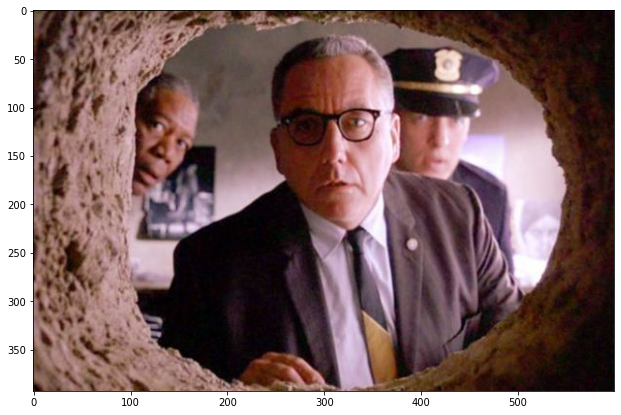

In [29]:
#display a random image  

plt.figure(figsize=(15,7))
plt.imshow(data[99][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


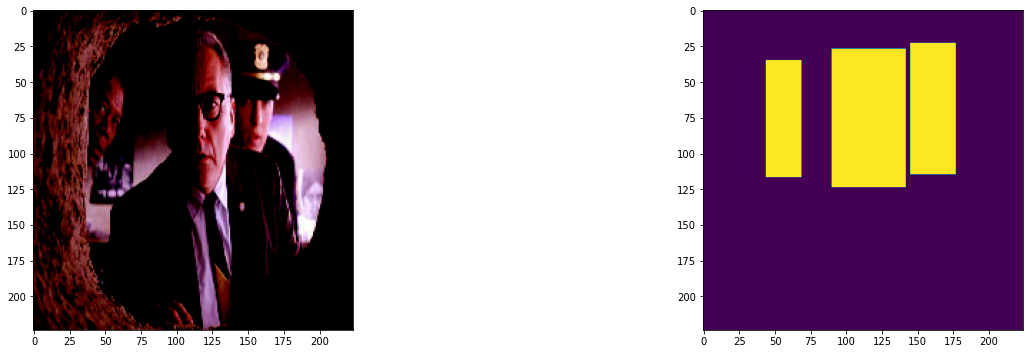

In [30]:
# random image and its related mask
plt.figure(figsize=(34,20))
plt.subplot(3,3,1)
plt.imshow(X_train[99])
plt.subplot(3,3,2)
plt.imshow(y_train[99])
plt.show()

In [20]:
X_train[99] # image array

array([[[-0.46666664, -0.67843139, -0.77254903],
        [-0.27058822, -0.47450978, -0.67058825],
        [-0.3098039 , -0.52156866, -0.72549021],
        ...,
        [-0.79607844, -0.97647059, -0.8509804 ],
        [-0.78823531, -1.        , -0.89019608],
        [-0.73333335, -1.        , -0.86666667]],

       [[-0.29411763, -0.49803919, -0.59215689],
        [-0.2235294 , -0.41176468, -0.62352943],
        [-0.23921567, -0.44313723, -0.64705884],
        ...,
        [-0.83529413, -0.98431373, -0.89019608],
        [-0.81960785, -1.        , -0.89803922],
        [-0.7647059 , -1.        , -0.88235295]],

       [[-0.24705881, -0.41960782, -0.52941179],
        [-0.13725489, -0.3098039 , -0.50588238],
        [-0.12156862, -0.29411763, -0.49803919],
        ...,
        [-0.88235295, -0.98431373, -0.90588236],
        [-0.85882354, -1.        , -0.9137255 ],
        [-0.78823531, -1.        , -0.89803922]],

       ...,

       [[-0.72549021, -0.89019608, -0.99215686],
        [-0

In [21]:
y_train[99] # masks

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Create the model  
- Add MobileNet as model with below parameter values
  - input_shape: 224, 224, 3
  - include_top: False -> to remove softmax layer
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers

**Four different Unet structures are implemented in this assignment**

**1. Simple Unet structure - Concatenation has been done only for couple of Upsampling layers**

In [48]:
def create_modelA(trainable=True):
    mobnet = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in mobnet.layers:
        layer.trainable = trainable

    block1 = mobnet.get_layer("conv_pw_5_relu").output
    block2 = mobnet.get_layer("conv_pw_11_relu").output
    block3 = mobnet.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = UpSampling2D()(x) # upsampling without concatenation and Conv2D layer
    x = UpSampling2D()(x) # upsampling without concatenation and Conv2D layer
    x = UpSampling2D()(x) # upsampling without concatenation and Conv2D layer
    
    x = Reshape((IMAGE_HEIGHT,IMAGE_WIDTH))(x)

    return Model(inputs=mobnet.input, outputs=x)  

**2. Unet structure - Concatenation has been done only for couple of Upsampling layers. Conv2D layers are implemented for every Upsampling layer. BatchNormalization and LeakyRelu activations are used.**

In [49]:
def create_modelB(trainable=True):
    mobnet = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in mobnet.layers:
        layer.trainable = trainable

    block1 = mobnet.get_layer("conv_pw_5_relu").output
    block2 = mobnet.get_layer("conv_pw_11_relu").output
    block3 = mobnet.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Conv2D(512, (3, 3), padding = 'same', kernel_initializer = 'he_normal')(x) #padding "same" is given to have the output image/array size same as input
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)

    x = Concatenate()([UpSampling2D()(x), block1])
    x = Conv2D(256, (3, 3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)

    x = UpSampling2D()(x)
    x = Conv2D(192, (3, 3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)

    x = UpSampling2D()(x)
    x = Conv2D(96, (3, 3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)

    x = UpSampling2D()(x)
    x = Conv2D(48, (3, 3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT,IMAGE_WIDTH))(x)

    return Model(inputs=mobnet.input, outputs=x)  

**3. Unet structure - Concatenation has been done for ALL the Upsampling layers. Conv2D layers are implemented for every Upsampling layer. BatchNormalization and Relu activations are used.** 

In [50]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_modelC(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = 1, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_HEIGHT,IMAGE_WIDTH))(x)
    return Model(inputs = model.input, outputs = x)

**4. Unet structure is implemented using segmentation.models.Unet**

In [55]:
BACKBONE1 = 'mobilenetv2'
base_model_unet = Unet(BACKBONE1, encoder_weights='imagenet', encoder_freeze=True)

inp = Input(shape=(224, 224, 3))
l1 = Conv2D(3, (1, 1))(inp) 

out = base_model_unet(l1)  

x1 = Conv2D(1, kernel_size =3,strides=1,padding = "same", activation="relu")(out)
x7 = Reshape((IMAGE_HEIGHT,IMAGE_WIDTH))(x1)
model4 = Model(inp, x7, name=base_model_unet.name) #Model(I = input layer, O = output after the base model, name = 'xxx')

### Call the create_model functions 

*Three model functions are called to create three models.*

In [52]:
model1 = create_modelA(False) 

17227776/17225924 [==============================] - 1s 0us/step


In [53]:
model2 = create_modelB(False)

In [54]:
model3 = create_modelC(False)

#### Print model summary 

In [56]:
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

**Trainable parameters are only 1,793. Lowest trainable parameters when compared to Unet structures.**

In [57]:
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

**Hightest trainable parameters when compared to other Unet structures.**

In [58]:
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

In [59]:
model4.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 224, 224, 3)       12        
_________________________________________________________________
model_5 (Model)              multiple                  8047441   
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 1)       10        
_________________________________________________________________
reshape_4 (Reshape)          (None, 224, 224)          0         
Total params: 8,047,463
Trainable params: 5,821,607
Non-trainable params: 2,225,856
_________________________________________________________________


#### Define dice coefficient function

In [62]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

#### Define loss function 

In [63]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### Compile the model 

*All the four models are compiled*

In [64]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [65]:
model1.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [66]:
model2.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [67]:
model3.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [68]:
model4.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define callbacks

In [69]:
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

**Fit the First model**

In [76]:
model1.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

Train on 400 samples, validate on 9 samples
Epoch 1/30
391/400 [============================>.] - ETA: 0s - loss: 0.9162 - dice_coefficient: 0.5635
Epoch 00001: val_loss did not improve from 0.84506
400/400 [==============================] - 2s 6ms/sample - loss: 0.9116 - dice_coefficient: 0.5641 - val_loss: 0.8608 - val_dice_coefficient: 0.5361
Epoch 2/30
399/400 [============================>.] - ETA: 0s - loss: 0.9098 - dice_coefficient: 0.5649
Epoch 00002: val_loss did not improve from 0.84506
400/400 [==============================] - 2s 6ms/sample - loss: 0.9093 - dice_coefficient: 0.5650 - val_loss: 0.8531 - val_dice_coefficient: 0.5369
Epoch 3/30
397/400 [============================>.] - ETA: 0s - loss: 0.9104 - dice_coefficient: 0.5652
Epoch 00003: val_loss did not improve from 0.84506
400/400 [==============================] - 2s 6ms/sample - loss: 0.9117 - dice_coefficient: 0.5643 - val_loss: 0.8627 - val_dice_coefficient: 0.5358
Epoch 4/30
399/400 [========================

In [79]:
result1 = model1.evaluate(X_test, y_test, verbose = 1)

9/9 [==============================] - 0s 2ms/sample - loss: 0.6774 - dice_coefficient: 0.6155


In [99]:
#Store the Dice Coefficient in a dataframe for final comparison
final_df = pd.DataFrame({'Models':['Simple_Unet'], 'Dice_Coeff': result1[1]},index={'1'})
final_df = final_df[['Models', 'Dice_Coeff']]
final_df

,Models,Dice_Coeff
1,Simple_Unet,0.615454


In [84]:
y_pred1 = model1.predict(X_test, verbose = 1)

9/9 [==============================] - 0s 3ms/sample


**Fit the Second model**

In [89]:
model2.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

Train on 400 samples, validate on 9 samples
Epoch 1/30
398/400 [============================>.] - ETA: 0s - loss: 0.6297 - dice_coefficient: 0.6574
Epoch 00001: val_loss did not improve from 0.84506
400/400 [==============================] - 7s 18ms/sample - loss: 0.6280 - dice_coefficient: 0.6581 - val_loss: 1.3995 - val_dice_coefficient: 0.4100
Epoch 2/30
397/400 [============================>.] - ETA: 0s - loss: 0.6262 - dice_coefficient: 0.6591
Epoch 00002: val_loss did not improve from 0.84506
400/400 [==============================] - 7s 18ms/sample - loss: 0.6249 - dice_coefficient: 0.6594 - val_loss: 1.4292 - val_dice_coefficient: 0.4066
Epoch 3/30
397/400 [============================>.] - ETA: 0s - loss: 0.6221 - dice_coefficient: 0.6607
Epoch 00003: val_loss did not improve from 0.84506
400/400 [==============================] - 7s 18ms/sample - loss: 0.6213 - dice_coefficient: 0.6608 - val_loss: 1.4097 - val_dice_coefficient: 0.4108
Epoch 4/30
397/400 [=====================

In [90]:
result2 = model2.evaluate(X_test, y_test, verbose = 1)

9/9 [==============================] - 0s 5ms/sample - loss: 1.1508 - dice_coefficient: 0.4884


In [100]:
temp_df = pd.DataFrame({'Models':['Unet_3_Upsampling_Concatenation'], 'Dice_Coeff': [result2[1]]},index={'2'})
final_df= pd.concat([final_df, temp_df])
final_df = final_df[['Models', 'Dice_Coeff']]
final_df

,Models,Dice_Coeff
1,Simple_Unet,0.615454
2,Unet_3_Upsampling_Concatenation,0.488425


In [92]:
y_pred2 = model2.predict(X_test, verbose = 1)

9/9 [==============================] - 0s 48ms/sample


**Fit the Third model**

In [93]:
model3.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

Train on 400 samples, validate on 9 samples
Epoch 1/30
397/400 [============================>.] - ETA: 0s - loss: 2.9349 - dice_coefficient: 0.2230
Epoch 00001: val_loss did not improve from 0.84506
400/400 [==============================] - 11s 28ms/sample - loss: 2.9314 - dice_coefficient: 0.2237 - val_loss: 3.5598 - val_dice_coefficient: 0.2228
Epoch 2/30
397/400 [============================>.] - ETA: 0s - loss: 2.5916 - dice_coefficient: 0.2635
Epoch 00002: val_loss did not improve from 0.84506
400/400 [==============================] - 8s 20ms/sample - loss: 2.5960 - dice_coefficient: 0.2627 - val_loss: 3.3229 - val_dice_coefficient: 0.2415
Epoch 3/30
397/400 [============================>.] - ETA: 0s - loss: 2.4227 - dice_coefficient: 0.2785
Epoch 00003: val_loss did not improve from 0.84506
400/400 [==============================] - 8s 20ms/sample - loss: 2.4188 - dice_coefficient: 0.2790 - val_loss: 3.0873 - val_dice_coefficient: 0.2529
Epoch 4/30
397/400 [====================

In [94]:
result3 = model3.evaluate(X_test, y_test, verbose = 1)

9/9 [==============================] - 1s 97ms/sample - loss: 1.6525 - dice_coefficient: 0.3929


In [101]:
temp_df = pd.DataFrame({'Models':['Unet_5_Upsampling_Concatenation'], 'Dice_Coeff': [result3[1]]},index={'3'})
final_df= pd.concat([final_df, temp_df])
final_df = final_df[['Models', 'Dice_Coeff']]
final_df

,Models,Dice_Coeff
1,Simple_Unet,0.615454
2,Unet_3_Upsampling_Concatenation,0.488425
3,Unet_5_Upsampling_Concatenation,0.392867


In [96]:
y_pred3 = model3.predict(X_test, verbose = 1)

9/9 [==============================] - 0s 53ms/sample


**Fit the Fourth model**

In [97]:
model4.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

Train on 400 samples, validate on 9 samples
Epoch 1/30
399/400 [============================>.] - ETA: 0s - loss: 3.6065 - dice_coefficient: 0.0856
Epoch 00001: val_loss did not improve from 0.84506
400/400 [==============================] - 16s 40ms/sample - loss: 3.6052 - dice_coefficient: 0.0857 - val_loss: 3.4898 - val_dice_coefficient: 0.0734
Epoch 2/30
399/400 [============================>.] - ETA: 0s - loss: 3.5669 - dice_coefficient: 0.0873
Epoch 00002: val_loss did not improve from 0.84506
400/400 [==============================] - 10s 25ms/sample - loss: 3.5667 - dice_coefficient: 0.0874 - val_loss: 3.4711 - val_dice_coefficient: 0.0738
Epoch 3/30
398/400 [============================>.] - ETA: 0s - loss: 3.5420 - dice_coefficient: 0.0885
Epoch 00003: val_loss did not improve from 0.84506
400/400 [==============================] - 10s 25ms/sample - loss: 3.5424 - dice_coefficient: 0.0885 - val_loss: 3.4499 - val_dice_coefficient: 0.0753
Epoch 4/30
398/400 [==================

In [98]:
result4 = model4.evaluate(X_test, y_test, verbose = 1)

9/9 [==============================] - 1s 130ms/sample - loss: 2.8096 - dice_coefficient: 0.1130


In [102]:
temp_df = pd.DataFrame({'Models':['Segmentation.models.Unet'], 'Dice_Coeff': [result4[1]]},index={'4'})
final_df= pd.concat([final_df, temp_df])
final_df = final_df[['Models', 'Dice_Coeff']]
final_df

,Models,Dice_Coeff
1,Simple_Unet,0.615454
2,Unet_3_Upsampling_Concatenation,0.488425
3,Unet_5_Upsampling_Concatenation,0.392867
4,Segmentation.models.Unet,0.112985


In [103]:
y_pred4 = model4.predict(X_test, verbose = 1)

9/9 [==============================] - 1s 90ms/sample


### Get the predicted mask for a test image

**Image displayed with original mask**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


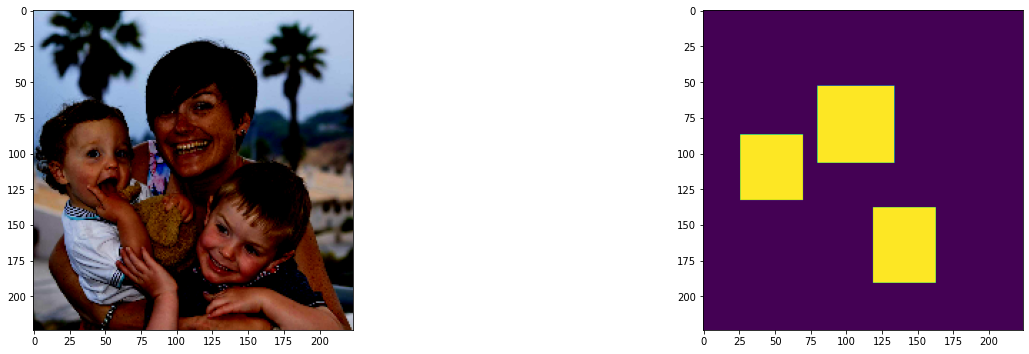

In [135]:
# Random test image to check the prediction
plt.figure(figsize=(34,20))
plt.subplot(3,3,1)
plt.imshow(X_test[0],alpha=1)
plt.subplot(3,3,2)
plt.imshow(y_test[0],alpha=1)
plt.show()

In [104]:
# Test image and Mask are resized to 224 X 224
n = 0
image = cv2.resize(X_test[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)

pred_mask1 = cv2.resize(1.0*(y_pred1[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT)) # prediction for 1st model
pred_mask2 = cv2.resize(1.0*(y_pred2[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT)) # prediction for 2nd model
pred_mask3 = cv2.resize(1.0*(y_pred3[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT)) # prediction for 3rd model
pred_mask4 = cv2.resize(1.0*(y_pred4[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT)) # prediction for 4th model

**Masks Predicted by Four models**

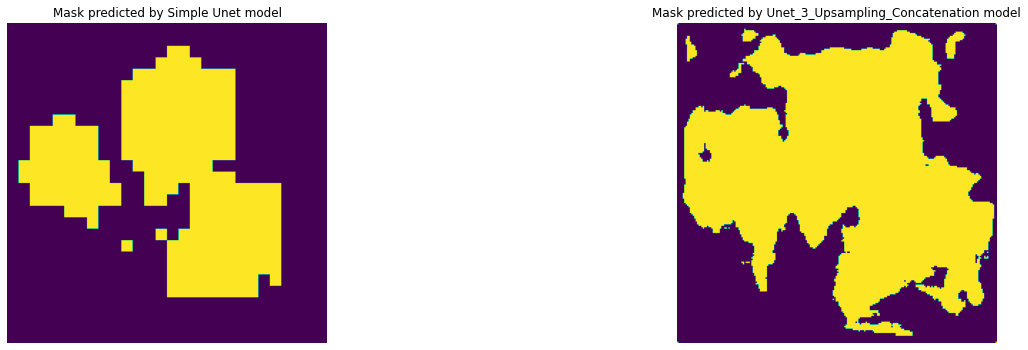

In [133]:
plt.figure(figsize=(34,20))
plt.subplot(3,3,1)
plt.axis('off')
plt.title("Mask predicted by Simple Unet model")
plt.imshow(pred_mask1, alpha = 1)
plt.savefig('pred_mask1.jpg', bbox_inches = 'tight', pad_inches = 0)
plt.subplot(3,3,2)
plt.axis('off')
plt.title("Mask predicted by Unet_3_Upsampling_Concatenation model")
plt.imshow(pred_mask2, alpha = 1)
plt.savefig('pred_mask2.jpg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

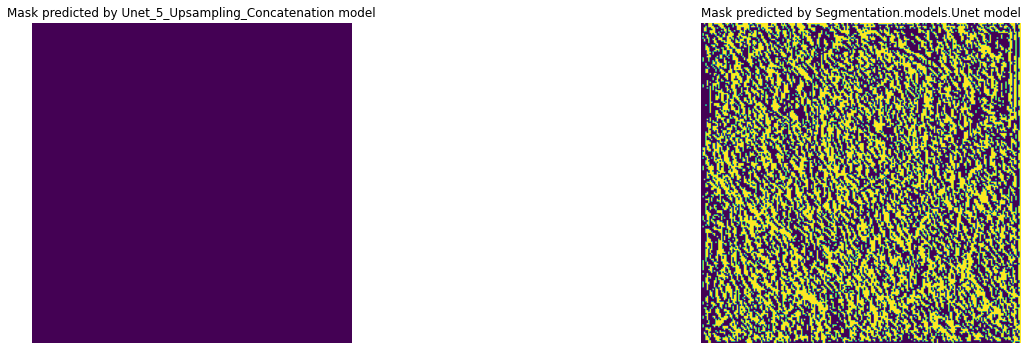

In [128]:
plt.figure(figsize=(34,20))
plt.subplot(3,3,1)
plt.axis('off')
plt.title("Mask predicted by Unet_5_Upsampling_Concatenation model")
plt.imshow(pred_mask3, alpha = 1)
plt.savefig('pred_mask3.jpg', bbox_inches = 'tight', pad_inches = 0)
plt.subplot(3,3,2)
plt.axis('off')
plt.title("Mask predicted by Segmentation.models.Unet model")
plt.imshow(pred_mask4, alpha = 1)
plt.savefig('pred_mask4.jpg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

**Out of 4 Unet architectures, Mask predicted by Simple Unet architecture fits the faces perfectly**  

### Impose the mask on the test image

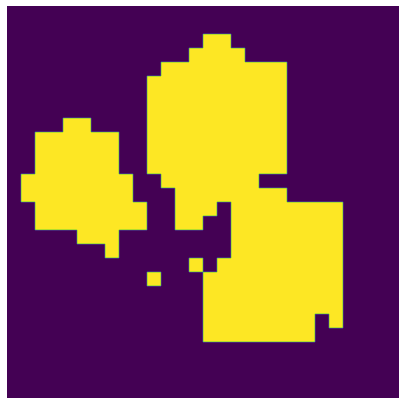

In [180]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask1, alpha = 1)
plt.savefig('mask1.jpg', bbox_inches = 'tight', pad_inches = 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


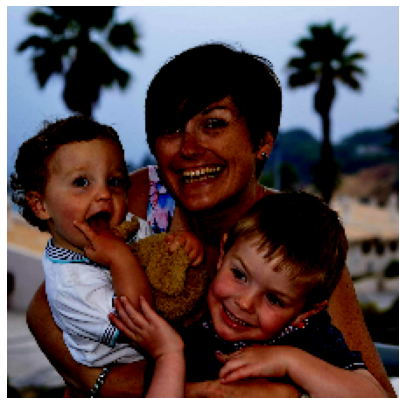

In [181]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_test[n], alpha=1)
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

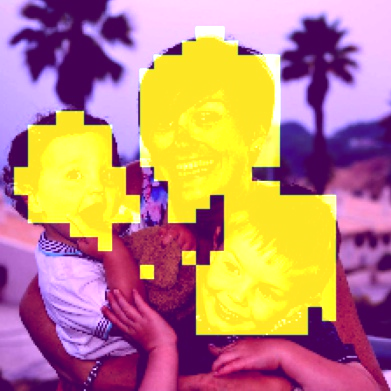

In [182]:
img = cv2.imread('image.jpg', 1)
pre_mask1 = cv2.imread('mask1.jpg', 1)
img = cv2.add(img, pre_mask1)
cv2_imshow(img) # cv2_imshow do not allow alpha parameter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


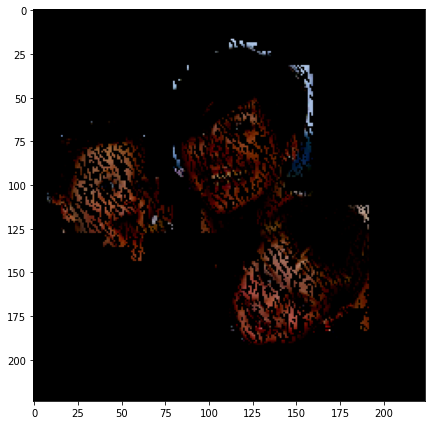

In [123]:
image1 = image
image1[:,:,0] = pred_mask1*image[:,:,0]
image1[:,:,1] = pred_mask1*image[:,:,1]
image1[:,:,2] = pred_mask1*image[:,:,2]
out_image1 = image1

plt.figure(figsize=(15,7.2))
#plt.subplot(3,3,1)
plt.imshow(out_image1)

**Unet model (Concatenation has been done only for couple of Upsampling layers, remaining layers were just upsampled without any Conv2D/Concatenation) successfully predicted the mask around the face in a given image. In addition, simplest Unet model has got the highest dice coefficient.**